# Rolling Kolmogorov Smirnov Test
We compare the PDF of the MFHT in each window with that of the window N-days apart

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime

from stabilvol.utility import functions as f

MARKETS = ["UN", "UW", "LN", "JT"]
START_DATE = "1980-01-01"
END_DATE = "2022-07-01"

VOL_LIMIT= 100  # Change this will change all the pickle files, remember to re-generate them
TAU_MAX = 30

WINDOWS_DURATION = 90  # days

In [2]:
def roll_windows(duration=90,  start_date=None, end_date=None):
    # Define the start and end dates
    start_date = datetime.date(1980, 1, 1) if start_date is None else start_date
    end_date = datetime.date(2022, 7, 1) if end_date is None else end_date
    
    half_win_len = pd.to_timedelta(duration//2, 'D')
    start = start_date + half_win_len
    end = end_date - half_win_len
    centers = pd.date_range(start, end, freq='D')
    return [(mid - half_win_len, mid + half_win_len) for mid in centers]

In [3]:
windows = roll_windows(duration=WINDOWS_DURATION, start_date=datetime.date(1985, 1, 1), end_date=datetime.date(2022, 12, 31))
len(windows)

13789

In [41]:
for i in experiments_map:
    print(i)

0


In [39]:
experiments_map = {
    0: dict(
        start_levels = [1.8, 1.4, 1., 0.6],
        deltas = [-0.2, -0.4, -0.8],
        n = 27,
    ),
    # dict(
    #     start_levels = [-1.8, -1.4, -1., -0.6],
    #     deltas = [0.2, 0.4, 0.8],
    #     n = 27,
    # ),
    # dict(
    #     start_levels = [1.8, 1.4, 1., 0.6],
    #     deltas = [-0.2, -0.4, -0.8],
    #     n = 90
    # ),
    # dict(
    #     start_levels = [1.8, 1.4, 1., 0.6],
    #     deltas = [-0.2, -0.4, -0.8],
    #     n = 120,
    # ),
    # dict(
    #     start_levels = [1.8, 1.4, 1., 0.6],
    #     deltas = [-0.2, -0.4, -0.8],
    #     n = 120,
    # ),
    # dict(
    #     start_levels = [-3.0, -2.6, -2.2, -1.8],
    #     deltas = [0.2, 0.4, 0.8]
    # ),
}
levels = {(round(start, 2), round(start+delta, 2)) for start in experiments_map[0]['start_levels'] for delta in experiments_map[0]['deltas']}
levels = sorted(levels)

In [42]:
df_markets = {}
for i, market in enumerate(MARKETS):
    df_maxs = []
    for j in experiments_map:
        try:
            p_values = np.load(f'../data/processed/dynamics/{market}_rolling_{WINDOWS_DURATION}d_KS_pvalue_{j+1}.npy')
            statistics = np.load(f'../data/processed/dynamics/{market}_rolling_{WINDOWS_DURATION}d_KS_statistic_{j+1}.npy')
            outcasts = np.load(f'../data/processed/dynamics/{market}_rolling_{WINDOWS_DURATION}d_KS_outcasts_{j+1}.npy')
        except FileNotFoundError:
            print(f'File not found for market {market} experiment {j+1}, skipping...')
            continue

        # Mask outcasts
        p_values[outcasts == 1] = np.nan
        coefficients = sorted({(round(start, 2), round(start+delta, 2)) for start in experiments_map[j]['start_levels'] for delta in experiments_map[j]['deltas']})
        start_delta = pd.MultiIndex.from_tuples([(l[0], round(l[1] - l[0], 2)) for l in coefficients], names=['start', 'delta'])
        df = pd.DataFrame(p_values.T, columns=start_delta)
        df_maxs.append(df)
        df_maxs = pd.concat(df_maxs, axis=1)
        df_markets[market] = df_maxs

df_markets = pd.concat(df_markets, keys=df_markets.keys(), names=['market', 'window'])
df_markets.to_pickle(f'../data/processed/dynamics/rolling_90d_KS_pvalues_all_markets.pkl')

print(f'Starting Thresholds used:\n{df_markets.columns.get_level_values(0).unique().sort_values()}')

Starting Thresholds used:
Index([0.6, 1.0, 1.4, 1.8], dtype='float64', name='start')


### Filter Data

In [21]:
df_markets

start               0.6                                       1.0  \
delta              -0.8          -0.4          -0.2          -0.8   
market window                                                       
UN     0       0.974433  1.773551e-04  1.413307e-08  1.773551e-04   
       1       0.950570  8.852297e-05  3.216171e-09  8.852297e-05   
       2       0.863802  3.568861e-05  1.140423e-08  3.568861e-05   
       3       0.840225  1.523572e-05  5.879704e-11  1.523572e-05   
       4       0.095676  9.887034e-08  1.063911e-11  9.887034e-08   
...                 ...           ...           ...           ...   
JT     13784        NaN           NaN           NaN           NaN   
       13785        NaN           NaN           NaN           NaN   
       13786        NaN           NaN           NaN           NaN   
       13787        NaN           NaN           NaN           NaN   
       13788        NaN           NaN           NaN           NaN   

start                                               1.4                \
delta                  -0.4          -0.2          -0.8          -0.4   
market window                                                           
UN     0       5.127340e-07  2.708366e-07  5.127340e-07  4.036577e-07   
       1       7.310617e-07  2.897526e-07  7.310617e-07  3.317693e-07   
       2       4.295234e-07  1.502556e-07  4.295234e-07  5.682753e-07   
       3       1.608700e-09  1.689506e-07  1.608700e-09  5.328986e-08   
       4       6.913462e-10  2.144138e-07  6.913462e-10  2.236383e-08   
...                     ...           ...           ...           ...   
JT     13784            NaN           NaN           NaN           NaN   
       13785            NaN           NaN           NaN           NaN   
       13786            NaN           NaN           NaN           NaN   
       13787            NaN           NaN           NaN           NaN   
       13788            NaN           NaN           NaN           NaN   

start                             1.8                      
delta              -0.2          -0.8      -0.4      -0.2  
market window                                              
UN     0       0.011693  4.036577e-07  0.687124  0.853472  
       1       0.007575  3.317693e-07  0.524773  0.894395  
       2       0.003887  5.682753e-07  0.457001  0.961613  
       3       0.003838  5.328986e-08  0.422118  0.800832  
       4       0.001320  2.236383e-08  0.391048  0.782918  
...                 ...           ...       ...       ...  
JT     13784        NaN           NaN       NaN       NaN  
       13785        NaN           NaN       NaN       NaN  
       13786        NaN           NaN       NaN       NaN  
       13787        NaN           NaN       NaN       NaN  
       13788        NaN           NaN       NaN       NaN  

[55156 rows x 12 columns]

In [22]:
filter_data = False
if filter_data:
    df = df_markets.drop(columns=[-3.0, -2.6, -2.2, 2.2, 2.6, 3.0], level=0)
else:
    df = df_markets

In [23]:
high_thresholds = sorted({t for t in df.columns.get_level_values(0).unique() if t > 0}, reverse=True)
crashes = sorted({d for d in df.columns.get_level_values(1).unique() if d < 0})
low_thresholds = sorted({t for t in df.columns.get_level_values(0).unique() if t < 0}, reverse=True)
rallies = sorted({d for d in df.columns.get_level_values(1).unique() if d > 0})
thresholds = high_thresholds + low_thresholds
deltas = crashes + rallies
print('High Thresholds:', high_thresholds)
print('Low Thresholds:', low_thresholds)


High Thresholds: [1.8, 1.4, 1.0, 0.6]
Low Thresholds: []


In [24]:
deltas

[-0.8, -0.4, -0.2]

In [25]:
# Create xlabels (windows centered at the first day of each year)
xtickslabels = []
xticks = []
for year in range(1985, 2022):
    for i, w in enumerate(windows):
        date = w[0] + (w[1] - w[0]) / 2
        if date.year == year:
            xtickslabels.append(date.strftime('%Y'))
            xticks.append(i)
            break
ylabels = high_thresholds + low_thresholds

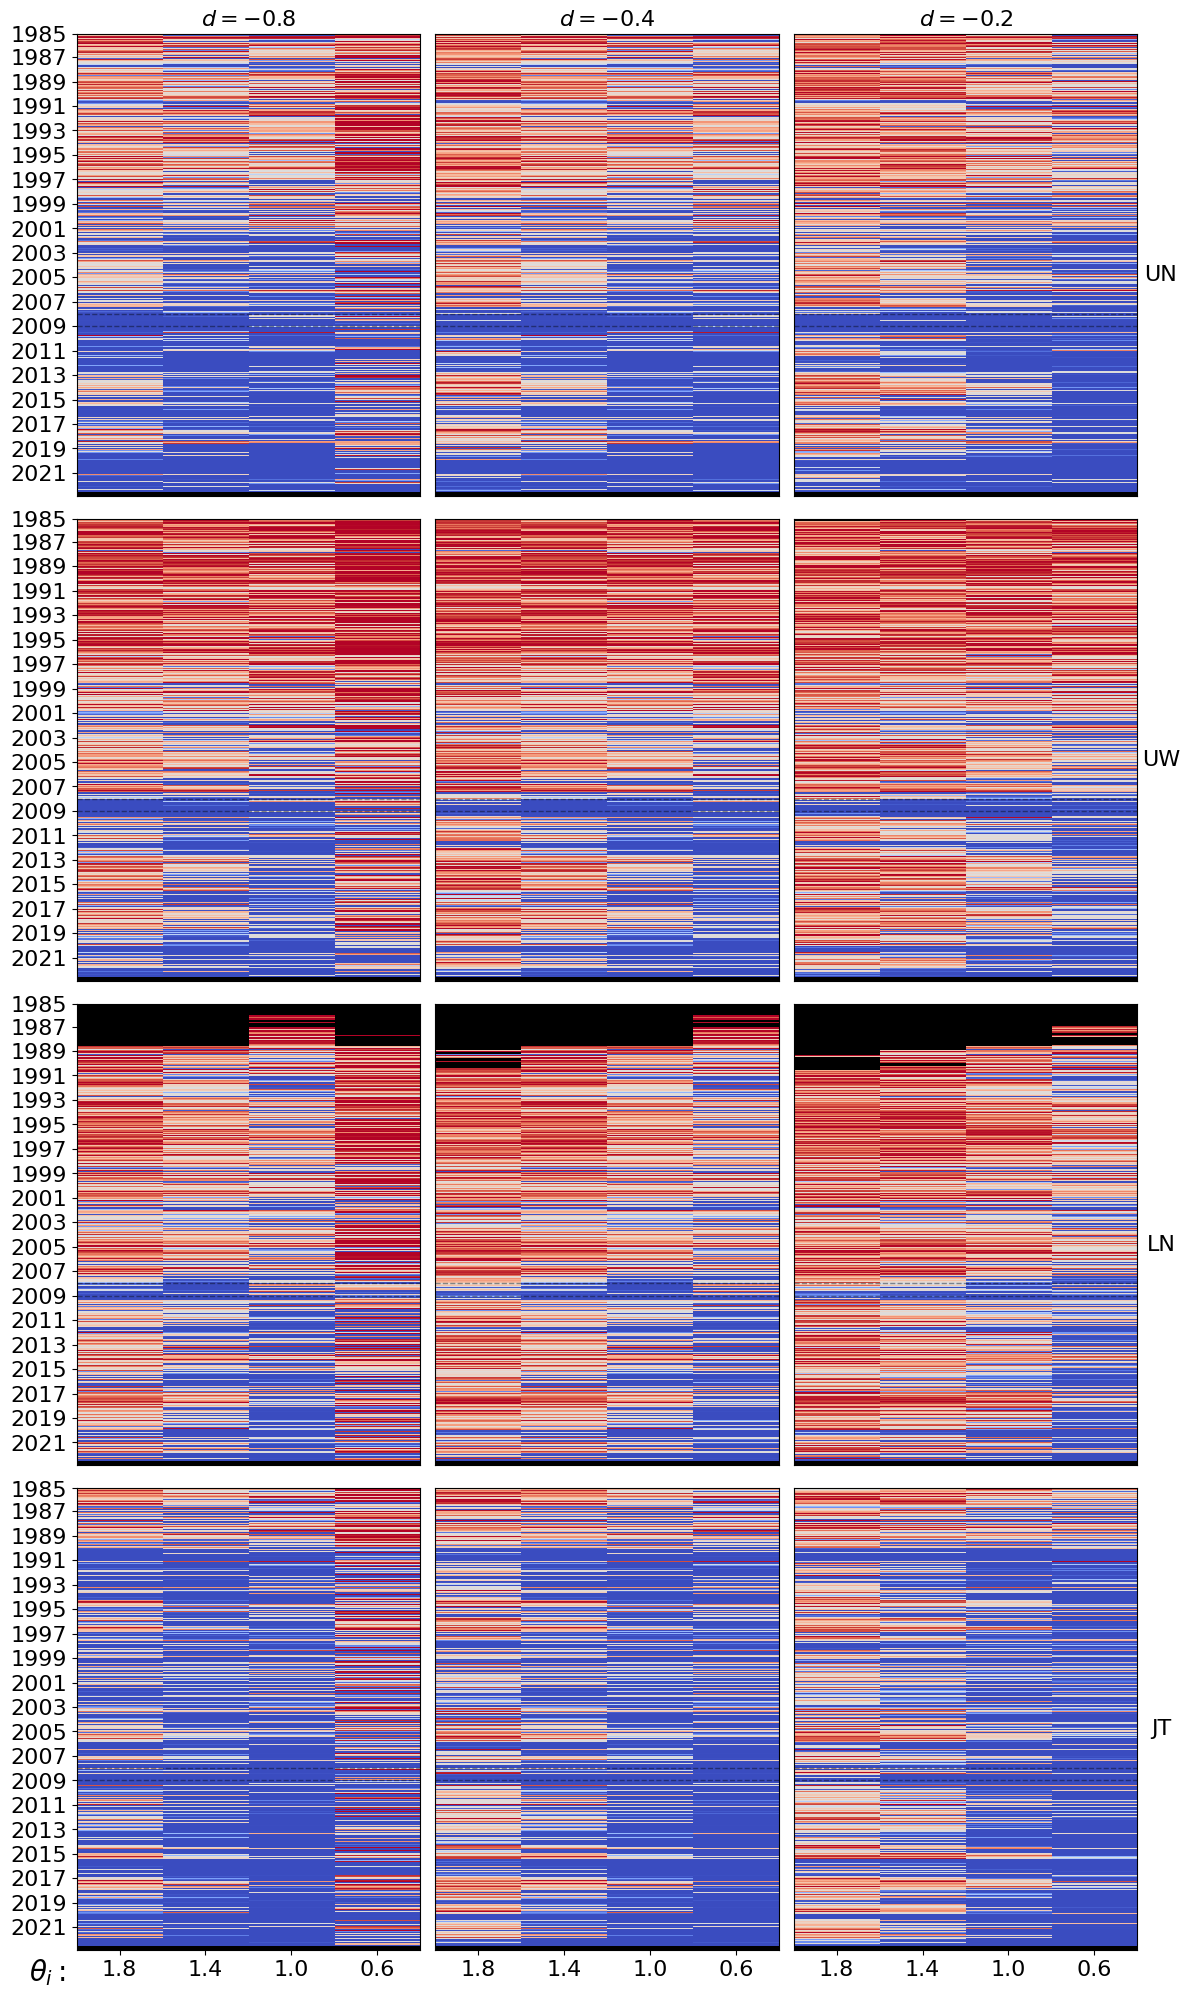

In [29]:
ACCEPT_THRESHOLD = 0.005

fig, axs = plt.subplots(4, 3, figsize=(12, 20), layout='tight')

# Create axes for colorbars
# cbar_axs = [fig.add_subplot(gs[i, 4]) for i in range(6)]
# for cax in cbar_axs:
#     cax.axis('off')

# Create colormap with black for masked values
norm = colors.TwoSlopeNorm(vmin=0, vcenter=ACCEPT_THRESHOLD, vmax=1)
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color='black')

for i, market in enumerate(MARKETS):

    for j, delta in enumerate(deltas):
        ax = axs[i, j]
        if j < len(crashes):
            data = df.loc[market, (high_thresholds, delta)]
            # ax.set_yticks(ax.get_yticks(), high_thresholds)
        else:
            data = df.loc[market, (low_thresholds, delta)]
            # ax.set_yticks(ax.get_yticks(), low_thresholds)
        im = ax.imshow(data, cmap=cmap, norm=norm, interpolation="nearest", aspect='auto')
        # Add colorbar
        # if i == len(MARKETS) - 1:
        #     cbar = fig.colorbar(im, ax=cbar_axs[j], orientation='vertical', use_gridspec=True)
        #     cbar.ax.set_title(f"$d={delta}$", fontsize=14)
        # Set titles
        
        # if j == len(deltas) - 1:
            # Set xlabels and ylabels
        yticks = ax.get_yticks()

for i, market in enumerate(MARKETS):
    for j, delta in enumerate(deltas):
        ax = axs[i, j]
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(f'$d = {delta}$', fontsize=16)
        elif i == len(MARKETS) - 1:
            ax.set_xticks(np.arange(len(high_thresholds)), high_thresholds if j < len(crashes) else low_thresholds, fontsize=16)
        if j == 0:
            ax.set_yticks(xticks[::2], xtickslabels[::2], rotation=0, fontsize=16)
        elif j == len(deltas) - 1:
            ax.set_ylabel(market, labelpad=17, rotation=0, fontsize=16)
            ax.yaxis.set_label_position('right')
        # Add dashed lines for 2007-2008 crisis
        start_crisis_window = np.where(np.array(xtickslabels) == '2008')[0][0]
        end_crisis_window = np.where(np.array(xtickslabels) == '2009')[0][0]
        ax.axhline(xticks[start_crisis_window], color='k', linestyle='--', linewidth=1, alpha=0.4)
        ax.axhline(xticks[end_crisis_window], color='k', linestyle='--', linewidth=1, alpha=0.4)

fig.text(0.028, 0.0188, '$\\theta_i :$', fontsize=20, verticalalignment='top', horizontalalignment='left')

fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_90d_KS_pvalues_grid_vertical.png')
fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_90d_KS_pvalues_grid_vertical.pdf')

plt.show()


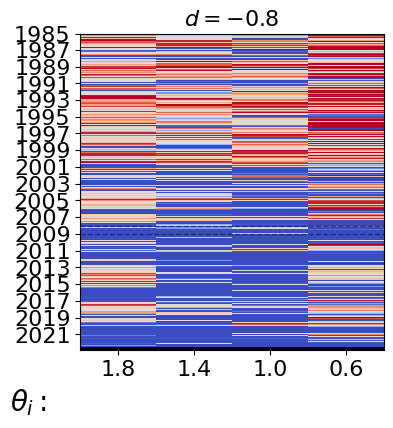

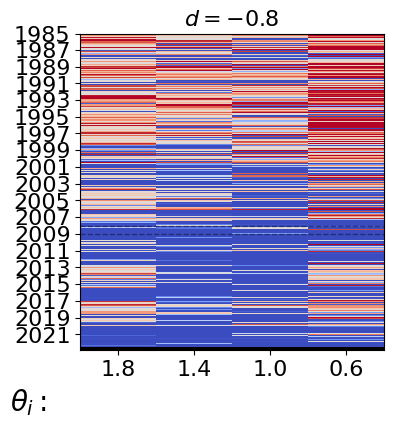

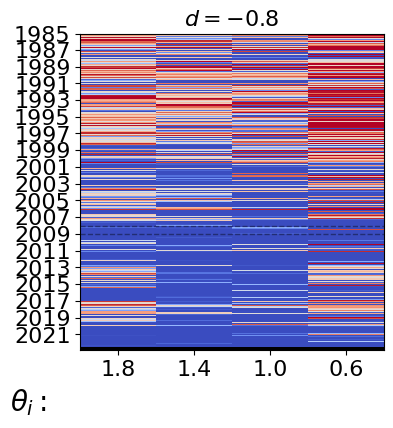

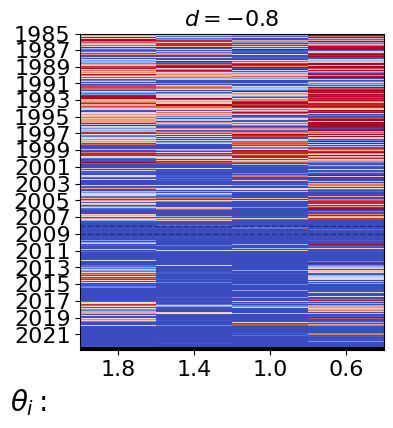

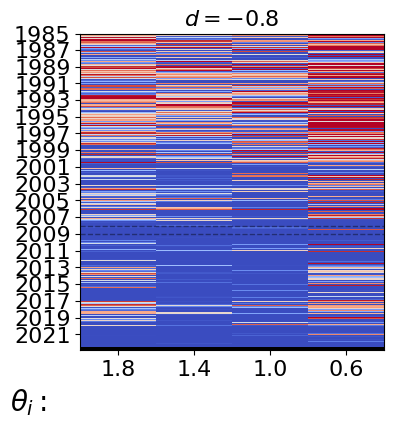

In [33]:
def plot_heatmaps(df, markets, deltas, high_thresholds, low_thresholds, crashes, rallies, accept_over=0.05):
    fig, axs = plt.subplots(len(markets), len(deltas), figsize=(4, 4), layout='tight')

    # Create axes for colorbars
    # cbar_axs = [fig.add_subplot(gs[i, 4]) for i in range(6)]
    # for cax in cbar_axs:
    #     cax.axis('off')

    # Create colormap with black for masked values
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=accept_over, vmax=1)
    cmap = plt.cm.coolwarm.copy()
    cmap.set_bad(color='black')

    for i, market in enumerate(markets):

        for j, delta in enumerate(deltas):
            ax = axs if not isinstance(axs, np.ndarray) else axs[i, j] if axs.ndim > 1 else axs[j]
            if j < len(crashes):
                data = df.loc[market, (high_thresholds, delta)]
                # ax.set_yticks(ax.get_yticks(), high_thresholds)
            else:
                data = df.loc[market, (low_thresholds, delta)]
                # ax.set_yticks(ax.get_yticks(), low_thresholds)
            im = ax.imshow(data, cmap=cmap, norm=norm, interpolation="none", aspect='auto')
            # Add colorbar
            # if i == len(MARKETS) - 1:
            #     cbar = fig.colorbar(im, ax=cbar_axs[j], orientation='vertical', use_gridspec=True)
            #     cbar.ax.set_title(f"$d={delta}$", fontsize=14)
            # Set titles
            
            # if j == len(deltas) - 1:
                # Set xlabels and ylabels
            yticks = ax.get_yticks()

    for i, market in enumerate(markets):
        for j, delta in enumerate(deltas):
            ax = axs if not isinstance(axs, np.ndarray) else axs[i, j] if axs.ndim > 1 else axs[j]
            ax.set_xticks([])
            ax.set_yticks([])
            if i == 0:
                ax.set_title(f'$d = {delta}$', fontsize=16)
            if i == len(markets) - 1:
                ax.set_xticks(np.arange(len(high_thresholds)), high_thresholds if j < len(crashes) else low_thresholds, fontsize=16)

            if j == 0:
                ax.set_yticks(xticks[::2], xtickslabels[::2], rotation=0, fontsize=16)
            elif j == len(deltas) - 1:
                ax.set_ylabel(market, labelpad=17, rotation=0, fontsize=16)
                ax.yaxis.set_label_position('right')
            # Add dashed lines for 2007-2008 crisis
            start_crisis_window = np.where(np.array(xtickslabels) == '2008')[0][0]
            end_crisis_window = np.where(np.array(xtickslabels) == '2009')[0][0]
            ax.axhline(xticks[start_crisis_window], color='k', linestyle='--', linewidth=1, alpha=0.4)
            ax.axhline(xticks[end_crisis_window], color='k', linestyle='--', linewidth=1, alpha=0.4)

    fig.text(0.028, 0.0188, '$\\theta_i :$', fontsize=20, verticalalignment='top', horizontalalignment='left')

    plt.show()

    return fig 

for p_threshold in [0.005, 0.01, 0.05, 0.1, 0.15]:
    fig = plot_heatmaps(df, ["UN"], [deltas[0]], high_thresholds, low_thresholds, crashes, rallies, accept_over=p_threshold)

# fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_90d_KS_pvalues_grid_vertical.png')
# fig.savefig(f'../visualization/dynamics/rolling_windows/rolling_90d_KS_pvalues_grid_vertical.pdf')

